# Import Packages

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as smote_pipe


from sklearn.metrics import (roc_auc_score, ConfusionMatrixDisplay, 
                             PrecisionRecallDisplay, RocCurveDisplay, 
                             f1_score, accuracy_score, recall_score, precision_score, classification_report)

# Load and Explore Data

In [2]:
#loading the data and indexing the first column because its a 
df = pd.read_csv('Data/stroke.csv', index_col=0)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


## Summary

* What I need to do to get my data prepared for the machine learning.

 -- Impute missing values in bmi column with SimpleImputer(strategy = 'mean')

  -- OneHotEncoder columns: gender, ever_married, work_type, residence_type, smoking_status.
  
  -- StandardScaler columns: age, avg_glucose_level, bmi.
  


# Validation Split

In [4]:
## Make X and y
target = 'stroke'
X = df.drop(columns=target).copy()
y = df[target].copy()

labels=['No Stroke', 'Stroke']
## train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print('Train Size', X_train.shape[0])
print('Test Size', X_test.shape[0])

Train Size 3832
Test Size 1278


# Get the ColumnTransformer

In [5]:
## instntiate column selectors. Get only the columns that needed to be transformered.
cat_selector = make_column_selector(dtype_include='object')
scal_cols = ['age', 'avg_glucose_level', 'bmi']



In [6]:
# Instantiate the transformers
scaler = StandardScaler() # for scal_cols
mean_imputer = SimpleImputer(strategy='mean') # this used for dealing with the missing values in bmi column.
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore') # for categorical columns.

In [7]:
## create a pipelines to put scaler and mean_imputer together for columns need to be impute missing values and standardscale..
num_pipe = make_pipeline(mean_imputer, scaler)

In [8]:
## combine the cols and transformers in a tuple.
num_tuple = (num_pipe, scal_cols)
cat_tuple = (ohe, cat_selector)

In [9]:
## finally, get the columntransformer.
preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000026E537C2220>),
                                ('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['age', 'avg_glucose_level', 'bmi'])])

## Check the Transforming Result.

In [10]:
## fit and transform the training dataset.
preprocessor.fit(X_train)
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
X_train_transformed.shape

(3832, 20)

In [11]:
# convert the training data to dataframe.
X_train_df = pd.DataFrame(X_train_transformed)
X_train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.737217,2.823301,1.926307,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.106549,-0.489814,-0.050820,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.381947,-0.411899,0.209329,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.515173,-0.941012,-0.141871,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.515173,0.109289,1.406011,0.0,0.0


# Machine Learning: Finding the Best Model.

In [12]:
# Checking the balance of class.
classes, counts = np.unique(y, return_counts=True)

for n in range(len(classes)):
  print(f'Class {classes[n]} has {counts[n]} members')

Class 0 has 4861 members
Class 1 has 249 members


In [17]:
y.value_counts(normalize='true')

0    0.951272
1    0.048728
Name: stroke, dtype: float64

We can see that the classes are not balanced. We will try use the SMOTE strategy to balance the class.

## Create an evaluation function for all models.

In [15]:
def evaluate_classiffication(model, X_test, y_test, label='Test Data', 
                             figsize=(15,5), normalize='true', classes=labels, 
                             cmap='Greens'): 
                             
    fig, axes = plt.subplots(1,2, figsize=figsize)

    
    test_pred = model.predict(X_test)
     
  
    print('---'*20)
    print(f"[i] CLASSIFICATION REPORT FOR: {label}")
    print('---'*20)

    print(classification_report(y_test, test_pred, target_names=classes))

    ConfusionMatrixDisplay.from_predictions(y_test,test_pred, 
                normalize=normalize, cmap=cmap, display_labels=classes,              
                ax=axes[0])    
    
    RocCurveDisplay.from_estimator(model, X_test, y_test,
                                   ax=axes[1])
    plt.show()

## Model 1: Logistic Regression Model

### Logistic Regression Model with Imbalanced Classes

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

   No Stroke       0.94      1.00      0.97      1198
      Stroke       1.00      0.01      0.02        80

    accuracy                           0.94      1278
   macro avg       0.97      0.51      0.50      1278
weighted avg       0.94      0.94      0.91      1278



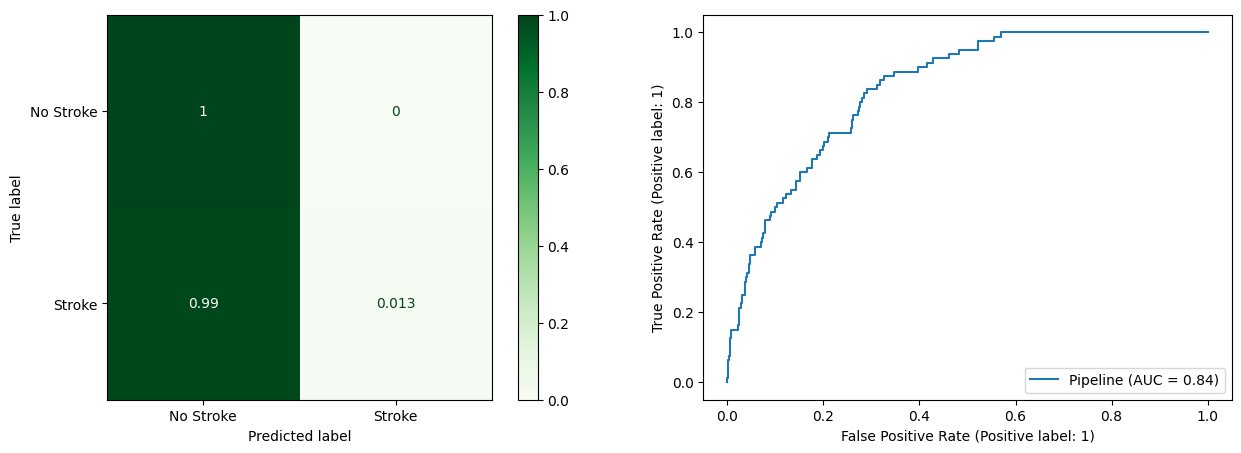

In [26]:
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg_pipe = make_pipeline(preprocessor, logreg)
logreg_pipe.fit(X_train, y_train)

evaluate_classiffication(logreg_pipe, X_test, y_test)

we can see that this model was very good at predicting the majority class, which are no stroke class. It identified all the no stroke class. However, it also classified 99% of the stroke as no stroke. The recall for the minaority class(stroke) is only 1%. 
We need to tell the model that the stroke is more important to identify than no stroke. 

### Logistic Regression Model with Balanced Classes

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

   No Stroke       0.98      0.76      0.85      1198
      Stroke       0.17      0.72      0.27        80

    accuracy                           0.75      1278
   macro avg       0.57      0.74      0.56      1278
weighted avg       0.93      0.75      0.82      1278



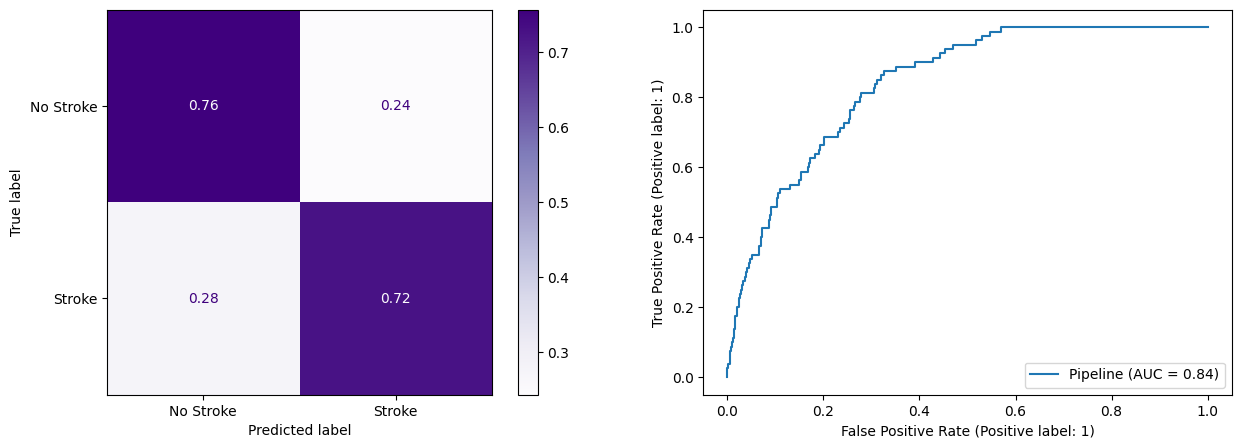

In [30]:
smote = SMOTE()
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg_smote_pipe = smote_pipe(preprocessor, smote, logreg)

logreg_smote_pipe.fit(X_train, y_train)

evaluate_classiffication(logreg_smote_pipe, X_test, y_test, cmap='Purples')

After balancing the classes, we can see that our recall for stroke was increased from 1% to 72%. However, our precision for stroke was decreased a lot to as low as only 17%, also the accuracy score also decreased. 

However, in this case, we try to predict as more stroke as possible. So, we need to keep trying to increase the recall score for stroke. 

Let's try to change the decision thresholds

### Logistic Regression Model with Best Decision Thresholds.

In [62]:
## create a function to find the best decision threshold.
def best_decision_threshold(model, X_test):
    test_probs = model.predict_proba(X_test)
    
    ## Create a function to convert
    def convert_probs_to_preds(probabilities, threshold, pos_class=1):
        
        predictions = [1 if prob[pos_class] > threshold else 0 for prob in probabilities]
        return predictions


## loop over the decision thresholds
    thresholds = np.arange(start=0, stop=1.05, step=.05)

    recalls = []
    precisions = []
    accuracies = []

    for thresh in thresholds: 

        preds = convert_probs_to_preds(test_probs, thresh)
 
        recalls.append(recall_score(y_test, preds))
        precisions.append(precision_score(y_test, preds))
        accuracies.append(accuracy_score(y_test, preds))
    
    # Plot precisions and recalls for each probability
    plt.figure(figsize=(15,5))
    plt.plot(thresholds, recalls, label='Recall')
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, accuracies, label='Accuracy')
    plt.legend()
    plt.title('Precision, Recall, and Accuracy Scores Across Decision Thresholds')
    plt.xlabel('Decision Thresholds')
    plt.ylabel('Score')
    plt.grid()
    plt.xticks(thresholds)
    plt.show()
    

C:\Users\qfu88\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


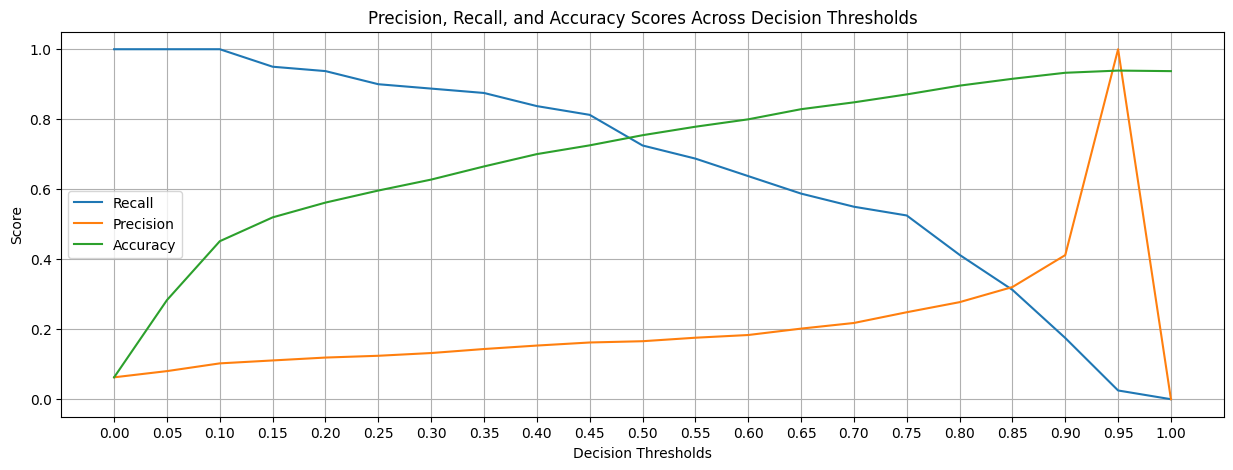

In [70]:
## we are using the model with the balanced classes.
best_decision_threshold(logreg_smote_pipe, X_test)

As we decided recall as our most important metric, so we want a higher recall score. As we can see, the precision score didn't change a lot until the threshold reached to 0.75. But too high threshold means a low recall. The accuracy gradually increase between threshold 0.3 to 0.55.

So, we might want to choose a threshold between 0.3 to 0.6. In this case, we will choose threshold of 0.4.

In [39]:
test_preds = convert_probs_to_preds(test_probs, .4)

              precision    recall  f1-score   support

           0       0.98      0.69      0.81      1198
           1       0.15      0.84      0.26        80

    accuracy                           0.70      1278
   macro avg       0.57      0.76      0.54      1278
weighted avg       0.93      0.70      0.78      1278



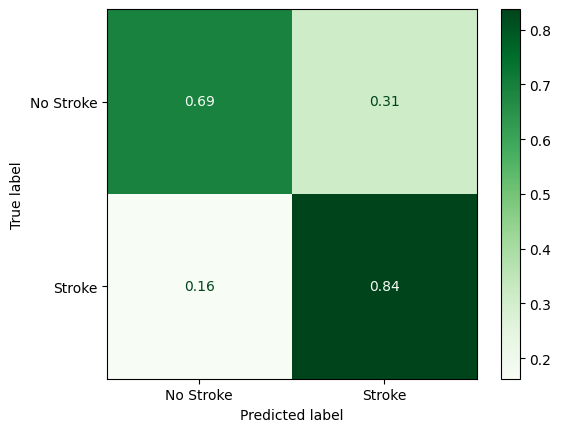

In [44]:
## we can't use the evaluate_classiffication function here.
## because can't use the arguments in the function to get the test_preds.

print(classification_report(y_test, test_preds))


ConfusionMatrixDisplay.from_predictions(y_test,test_preds, 
                normalize='true', cmap='Greens', display_labels=labels             
                )    
    

plt.show()

After change decision threshold from default 0.5 to 0.4, the recall score increased from 0.72 to 0.84. As results, the precision score decreased from 0.17 to 0.15 and accuracy score decreased from 0.75 to 0.7.

we can see that recall score increased a lot more than precision score and accuracy score decreased. 

So we can say that decision threshold of 0.4 is better than 0.5. 

Let's keeping trying other models.

**As our dataset doesn't have a large number of features and there is no high correlation between features. So we are not going to tune the L1 and L2 Regularization with our Logistic Regression Model.**

# Model 2: RandomForest Model

### RandomForest Model with Balanced Classes.

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: RandomForest - Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

   No Stroke       0.94      0.98      0.96      1198
      Stroke       0.28      0.10      0.15        80

    accuracy                           0.93      1278
   macro avg       0.61      0.54      0.55      1278
weighted avg       0.90      0.93      0.91      1278



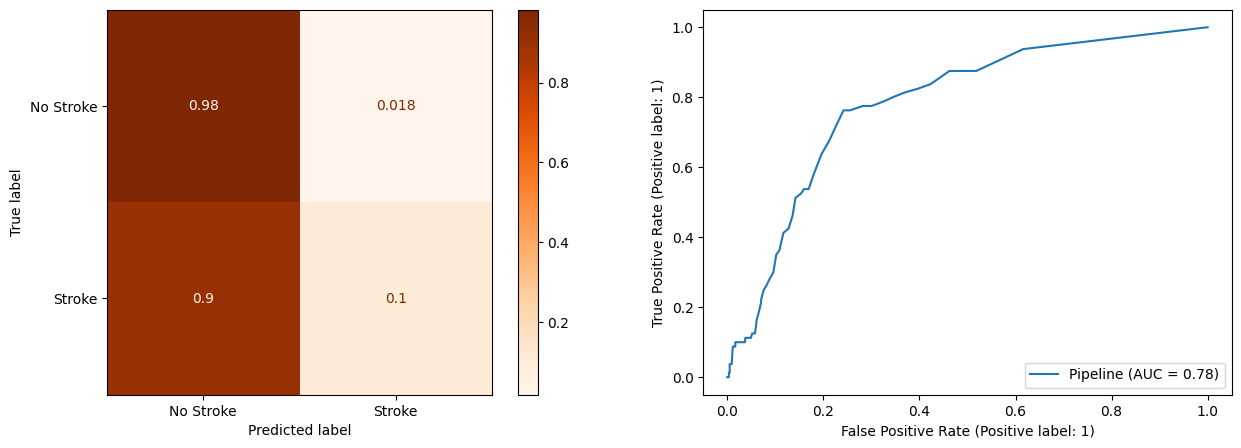

In [47]:
smote = SMOTE()
rf_smote = RandomForestClassifier(random_state=42)
rf_smote_pipe = smote_pipe(preprocessor, smote, rf_smote)

rf_smote_pipe.fit(X_train, y_train)

evaluate_classiffication(rf_smote_pipe, X_test, y_test, cmap='Oranges', label='RandomForest - Test Data')

Compared to logistic regression model with the balanced classes, the RandomForest Model with the balanced classes also did a very poor job on predicting the stroke as both recall and precision scores are very low on stroke class.

And the AUC score also lower than the AUC score of Logistic Regression Model



### Tuned RandomForest Model

In [50]:
tuned_rf = RandomForestClassifier(random_state=42, class_weight='balanced')
tuned_rf_pipe = make_pipeline(preprocessor, tuned_rf)

tuned_rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000026E537C2220>),
                                   ('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    ['age', 'avg_glucose_level', 'bmi'])])),
  ('randomforestclassifier',
   RandomForestClassifier(class_weight='balanced', random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='pass

In [58]:
# Number of trees in random forest
n_estimators = [10, 50, 100]

# Maximum number of levels in tree
max_depth = [5, 10, 60]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

param_grid = {'randomforestclassifier__n_estimators': n_estimators,
             'randomforestclassifier__max_depth': max_depth,
             'randomforestclassifier__min_samples_split': min_samples_split}


In [59]:
tuned_rf_pipe_gs = GridSearchCV(tuned_rf_pipe, param_grid)

tuned_rf_pipe_gs.fit(X_train, y_train)

best_rf = tuned_rf_pipe_gs.best_estimator_

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned RandomForest - Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

   No Stroke       0.94      1.00      0.97      1198
      Stroke       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



C:\Users\qfu88\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qfu88\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qfu88\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


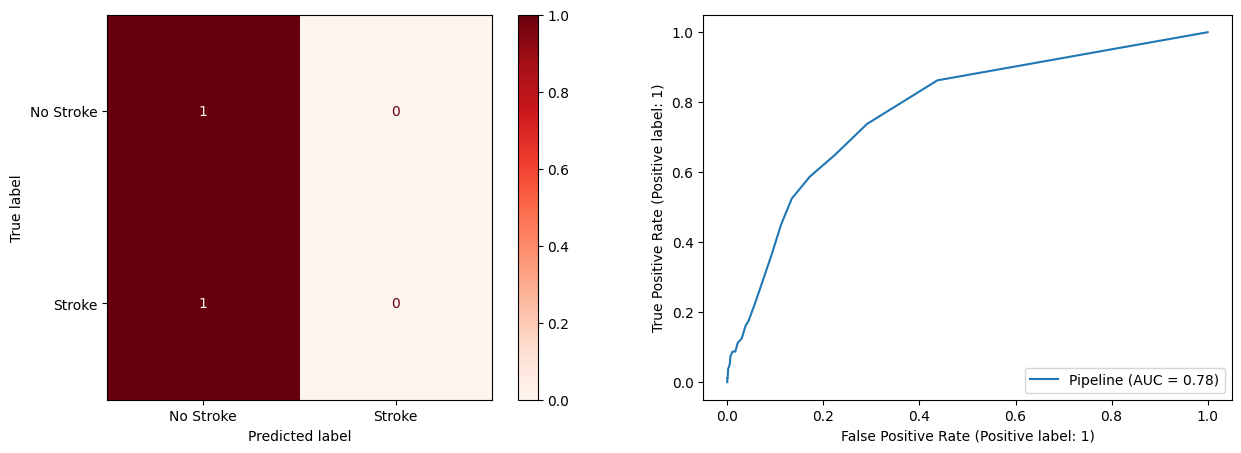

In [60]:
evaluate_classiffication(best_rf, X_test, y_test, cmap='Reds', label='Tuned RandomForest - Test Data')

As I tried to tune multiple hyperparameters, but it seems that we didn't get a better result as the model made a very bad prediction on stroke with zero score on both recall and precision.



### RandomForest Model with Best Decision Threshold

C:\Users\qfu88\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qfu88\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qfu88\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qfu88\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_cl

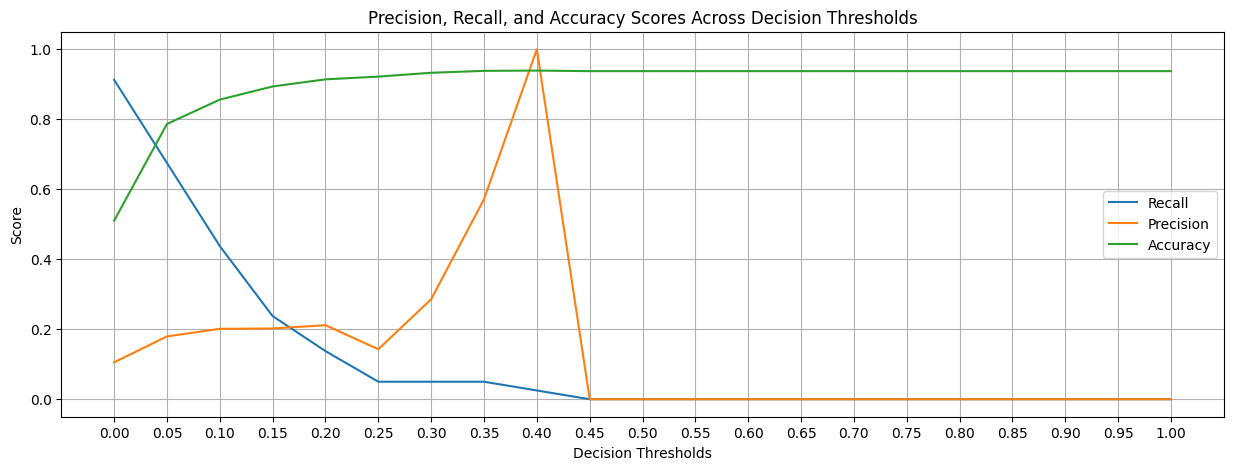

In [69]:
DT_rf = RandomForestClassifier(random_state=42, class_weight='balanced')
DT_rf_pipe = make_pipeline(preprocessor, DT_rf)
DT_rf_pipe.fit(X_train, y_train)

best_decision_threshold(DT_rf_pipe, X_test)

As we can see that if we use the same threshold of 0.4 as we used for logistic regression model, both the precision score and accuracy score at the highest. However, in this case, we are using recall as the most important metric as we try to predict as more stroke as possible. The recall score at the threshold of 0.4 almost down to 0.

we can see that both the accuracy and recall score are very high when the threshold is 0.05. However, the precision score is very low, but at this point, we choose higher recall and accuracy score.

In [71]:
test_preds = convert_probs_to_preds(test_probs, .05)

              precision    recall  f1-score   support

           0       1.00      0.24      0.38      1198
           1       0.08      1.00      0.15        80

    accuracy                           0.28      1278
   macro avg       0.54      0.62      0.26      1278
weighted avg       0.94      0.28      0.37      1278



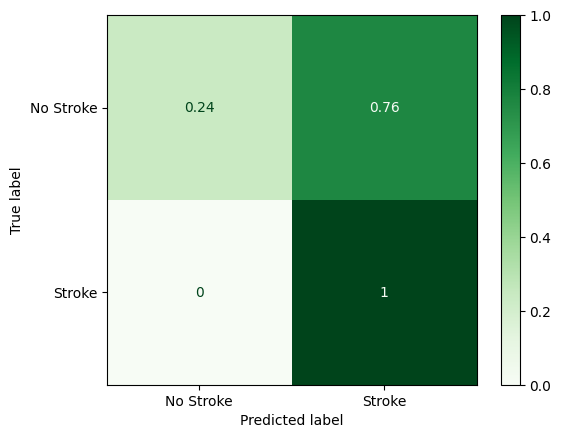

In [72]:
print(classification_report(y_test, test_preds))


ConfusionMatrixDisplay.from_predictions(y_test,test_preds, 
                normalize='true', cmap='Greens', display_labels=labels             
                )    
    

plt.show()

when we use threshold of 0.05, the model made a perfect prediction on stroke as it predicted all the samples as stroke, which didn't make sense here.

Let's keep trying other models.